# Heat equation

## imports

In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

## initialization

In [3]:
X_max = 50
Y_max = 70
X_min = Y_min = 0

NUMBER_X = 50
NUMBER_Y = 70
DELTA = 30

In [4]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [5]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

U = np.zeros_like(X)
U_coef = np.zeros_like(X)

source = np.zeros_like(X)
source_coef = np.zeros_like(X)

alpha = np.zeros_like(X_RANGE)
beta = np.zeros_like(X_RANGE)

In [6]:
source = np.exp(- ((X - int(X_max / 2 - 1)) ** 2 + (Y - int(Y_max / 2 - 1)) ** 2) / DELTA ** 2)

In [7]:
def calculate_coefficients(alpha, beta, s, lam):
    
    a = b  = 1 / X_STEP ** 2
    c = 2 / X_STEP ** 2 + lam / Y_STEP ** 2
    d = s
    
    for i in range(1, len(s)-1):
        alpha[i+1] = b / (c - alpha[i] * a)
        beta[i+1] = (a * beta[i] + d[i]) / (c - alpha[i] * a)
    return alpha, beta

def heatmap2d(arr: np.ndarray, interpolation=None):
    
    plt.imshow(arr.T, cmap='hot', interpolation=interpolation)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    ax = plt.gca()
    ax.invert_yaxis()

## boundary conditions

In [8]:
U_LOWER = 0         # lower bound
U_UPPER = 0         # upper bound
Q_LEFT  = 0         # left bound
U_RIGHT = 0         # right bound

alpha[1] = 1
beta[1] = Q_LEFT
U[-1,:] = U_RIGHT

## main procedure

In [9]:
for m in range(1, NUMBER_Y-1):
    source_coef[:,m] = 2 / NUMBER_Y * (source * np.sin(np.pi * m * Y / (Y_max - Y_min))).sum(axis=1)

lambdas = 4 * (np.sin(np.pi * np.arange(1, NUMBER_Y) / 2 / NUMBER_Y)) ** 2 

In [10]:
for j in tqdm_notebook(list(range(0, NUMBER_Y-1))):
    alpha, beta = calculate_coefficients(alpha, beta, source[:,j], lambdas[j])

    for i in reversed(range(0, NUMBER_X-1)):
        U_coef[i, j+1] = alpha[i+1] * U_coef[i+1, j+1] + beta[i+1]

In [11]:
for j in range(0, NUMBER_Y-1):
    U[:,j] = (U_coef * np.sin(np.pi * j * Y / (Y_max - Y_min))).sum(axis=1)

## vizualization

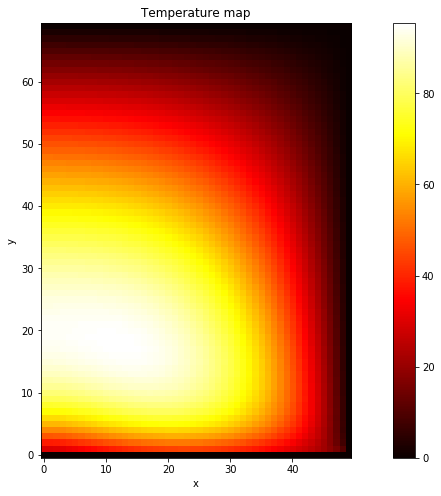

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
heatmap2d(U)

ticks = ax.get_xticks()
ax.set_xticklabels([str(int(X_min + x * (X_max - X_min) // (NUMBER_X)))
                    for x in ticks])

ticks = ax.get_yticks()
ax.set_yticklabels([str(int(Y_min + x * (Y_max - Y_min) // (NUMBER_Y)))
                    for x in ticks]);